# Maize Selection Trade-offs

Jupyter notebook describes ecohydrological model developed by Natasha Krell, Noah Spahn and Kelly Caylor to demonstrate crop water use of maize under various rainfall climatologies in central Kenya. The script below runs the model, simulates rainfall, outputs the results, and generates figures.

Last updated: 26 September 2019

## 1. Background
From Ridge to Reef notebook, Chapter 3.

### Tradeoffs between days to maturity and exposure to climate variability

This tradeoff is harder to quantify. Instead, we will model the interaction between days to maturity and crop failure. Our strategy will be to examine a very field-scale water balance that looks only at relative water availability \[mm/mm\], $s$, daily rainfall, $R$ \[mm/day\], and daily water demand, which we will characterize as reference evapotranspiration, $ET_0$ \[mm/day\]. Because temperature is relatively constant, we will assume that $ET_0$ is constant. Therefore our water balance is simply:


$$ \frac{dS}{dt} = R(t) - ET_0 $$

Note: need this equation to match what's in the model: dsdt(t) = R(t) - E(s,t) - L(s,t) - Q(s,t)

This formulation ignores many important processes related to soil water storage and plant response to drought. As defined, it is essentially a cumulative dryness index; during periods of the season when $\sum_t R(t) > t \times ET_0$, there will accumulation of water in the soil. During periods when $\sum_t R(t) < t \times ET_0$, the soil will dry out. 

Because the amount of plant available water in the soil in bounded between zero and some maximum, we add an additional parameter, $S_{max}$, which is the maximum amount of water `[mm]` that can be stored in the root zone. Now our model looks like this:

$$
\begin{eqnarray}
    \frac{dS}{dt} &=& R(t) - ET_0 & if & (0 \leq S \leq S_{max}) \\
    & & & else; \\
    \frac{dS}{dt} &=& 0 
\end{eqnarray}       
$$

Assuming a typical value of porosity is 0.4 and soil depth is 500 mm (0.5 meters), the value of $S_{max}$ is 200, here is what our model looks like in python:

```python
n = 0.4  # Porosity, [m3/m3]
Zr = 500 # Rooting depth [mm]
S_max = n*Zr    # Max soil water storage [mm]
S[0] = 30  # Initial soil water storage [mm]
ET_0 = 6.5 # Daily reference evapotranspiration [mm]

S = np.zeros(len(R)) # Pre-allocate the array for S
dSdt = np.zeros(len(R))# Pre-allocate the array for dSdt

for t in range(len(R)):
    dSdt[t] = R[t] - ET_0
    S[t+1] = S[t] + dSdt[t]
    if S[t+1] < S_max:
        S[t+1] = S_max
    if S[t+1] < 0:
        S[t+1] = 0
```

## 2. Import ecohydro model

Model is saved as `runmodel.py` in folder. Evaporation and transpiration are seperated to calculate ET. 

In [1]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
#os.chdir('../maize-Toff')

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel

In [11]:
# initialize objects
climate = Climate() # uses default climate values
soil = Soil('loam')
crop = Crop(soil=soil) # previously kc_max=1.2, LAI_max=2.0, T_max=4.0
soil.set_nZr(crop)  
model = CropModel(crop=crop,soil=soil,climate=climate)

model.run()
model.output()

done


,kc,LAI,R,s,E,ET,T,L,dsdt
0,0.300000,0.750000,0.000000,0.300000,0.027844,0.027844,0.000000,0.000000,-0.027844
1,0.300000,0.750000,0.000000,0.299877,0.027729,0.027729,0.000000,0.000000,-0.027729
2,0.300000,0.750000,0.000000,0.299754,0.027616,0.027616,0.000000,0.000000,-0.027616
3,0.300000,0.750000,0.000000,0.299631,0.027502,0.027502,0.000000,0.000000,-0.027502
4,0.300000,0.750000,0.000000,0.299509,0.027390,0.027390,0.000000,0.000000,-0.027390
5,0.300000,0.750000,26.398623,0.299388,0.027278,0.027278,0.000000,0.000000,26.371345
6,0.300000,0.750000,0.000000,0.416334,0.240490,0.513123,0.272633,0.000000,-0.513123
7,0.300000,0.750000,17.953406,0.414058,0.234323,0.499770,0.265447,0.000000,17.453635
8,0.300000,0.750000,0.000000,0.491458,0.489054,0.998921,0.509867,0.000000,-0.998921
9,0.300000,0.750000,13.777062,0.487028,0.471975,0.967853,0.495878,0.000000,12.809208


### a. Inspecting the model

In [3]:
# this should be the first term of LAI
pow(3.0/1.2,1)*0.3

# this should be the first E term
6.5*exp(-6.5*0.75)

0.04962811242258975

#### Make several plots

In [4]:
# set variables for all figures

s = np.arange(0, 1, 0.0056) #relative soil moisture
d = np.arange(1, 180, 1) #day

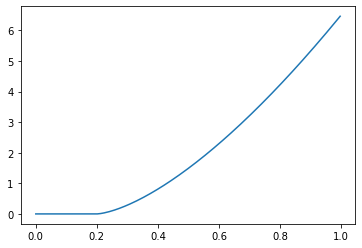

In [5]:
## Why can't I use calc_E()? I have been trouble shooting this a lot (Question 1.)
## calc_E requires s, t
plt.plot(s,[climate.calc_E(x, q=1.5, LAI=0, sh=0.2) for x in s])

In [6]:
s = np.arange(0, 1, 0.0056) #saturation
d = np.arange(1, 180, 1) #day



In [7]:
# climate.calc_E: Relative soil moisture and evaporation



#plt.plot(rs, climate.calc_E(rs, rs), '-')
#plt.plot(rs, [crop.calc_LAI(s,p=2) for s in rs], '--')
#plt.xlabel('s')
#plt.ylabel('E')
#plt.title('Relationship between s and E')

# this is not what we want
# plt.plot(model.s, model.E)

# What is Emax?
#ETmax = model.ET_max; #print(ETmax)
#model.output()
#model.ET_max
#climate.calc_E(model.s, np.arange(1,180))
#maxET = max(model.ET); print(maxET)

Text(0, 0.5, 'E')

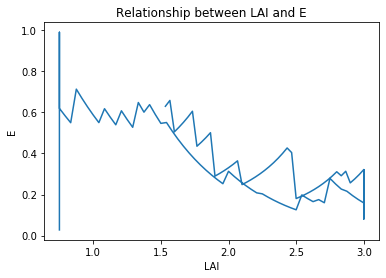

In [8]:
# LAI and evporation

plt.plot(model.LAI, model.E)
plt.title('Relationship between LAI and E')
plt.xlabel('LAI')
plt.ylabel('E')

Text(0, 0.5, 'LAI')

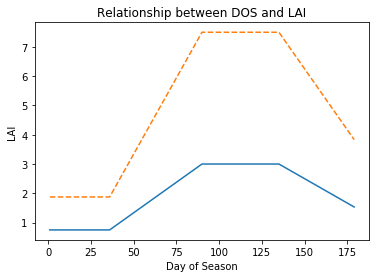

In [9]:
# LAI and relative soil moisture

#climate.ET_max
#climate.calc_E(np.arange(180), np.arange(180))
#crop.calc_LAI(np.arange(1,180))

#plot calc_LAI
plt.plot(d, [crop.calc_LAI(s,p=1) for s in d], '-')
plt.plot(d, [crop.calc_LAI(s,p=2) for s in d], '--')
plt.title('Relationship between DOS and LAI')
plt.xlabel('Day of Season')
plt.ylabel('LAI')

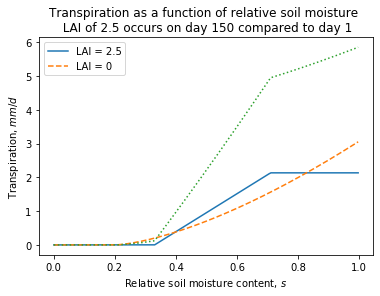

In [18]:
# Relative soil moisture and transpiration
# Need to plot for multiple LAIs


#plt.plot(model.s, model.T)
plt.plot(s, [crop.calc_T(x, 50) for x in s], '-')
#plt.plot(s, [crop.calc_T(x, 1) for x in s], '--')
plt.plot(s, [climate.calc_E(x, q=1.5, LAI=1.5, sh=0.2) for x in s],'--')
plt.plot(s, [crop.calc_T(x, 150) + climate.calc_E(x, q=1.5, LAI=2.5, sh=0.2) for x in s],':')

plt.title('Transpiration as a function of relative soil moisture \n LAI of 2.5 occurs on day 150 compared to day 1')
plt.xlabel('Relative soil moisture content, $\mathit{s}$')
plt.ylabel('Transpiration, $\mathit{mm/d}$')
plt.legend(['LAI = 2.5','LAI = 0'])


In [ ]:
# Evaporation and Time
d = np.arange(181)
plt.plot(model.E, '-')
plt.title('Relationship between E and Time of Season')
plt.xlabel('Time of Season, $\mathit{t}$')
plt.ylabel('Evaporation, mm/day')

In [ ]:
# Create Liao et al. Figure 5

# Plot s from model output
o = model.output()
o['s'].plot()

plt.title('Relative soil moisture in model.output')
plt.ylabel('Relative soil moisture, $\mathit{mm}$')
plt.xlabel('Time of season, $\mathit{d}$')
plt.show()

In [ ]:
# unsure about this one
# plot calc_E
plt.plot(rs, [climate.calc_E(s,1) for s in rs], '-')
plt.plot(rs, [climate.calc_E(s,2) for s in rs], '--')
plt.title('Effect of LAI on evaporation as a function of relative soil moisture')
plt.xlabel('Relative soil moisture content, $\mathit{s}$')
plt.ylabel('Evaporation, $\mathit{E}$')
plt.legend(['LAI = 5','LAI = 0'])
#plt.show()
#plt.axhline(y=2, color='black', linewidth=1.5)

#calc_E(4,1)

In [ ]:
# kc and LAI: plant.calc_LAI
# Can input calc_LAI manually

crop = Crop(soil=soil)
crop.calc_LAI(100)

self = crop
self.T_max

self.sw

def calc_LAI(self, day_of_season, p=1):
        """ Returns a Leaf Area Index (LAI) variable. LAI comes
            from function of kc. Currently based on linear relationship 
            between kc and LAI (assumption).
        
        Usage: calc_LAI(t, p=1)

        LAI = (LAI_max/kc_max)^p * kc(t),

        where kc varies through the season according to calc_kc(t) 

        Note: p=1 assumes a linear relationship between LAI and kc

        """
        return pow((self.LAI_max/self.kc_max),p) * self.calc_kc(day_of_season)


In [ ]:
#self.calc_LAI(1)

p=1
day_of_season = 1
pow((self.LAI_max/self.kc_max),p) * self.calc_kc(day_of_season)

self.calc_LAI(1)

plt.plot(model.kc, model.LAI)
plt.title('Relationship between Kc and LAI')
plt.ylabel('LAI')
plt.xlabel('Kc')


### b. Model tests

Something is wrong with `s`, `theta`, or `psi`, which are all methods of Soil. To figure out which of these might be causing the issue, we can test various relative soil moisture values using this figure from Liao et al. 2001b showing the relationship between relative soil moisture (x-axis: low levels of soil moisture = 0 and max soil moisture = 1) and evapotranspiration (y-axis: the sum of losses from both plant transpiration and soil evaporation).

![Create figure 5 from Liao et al. 2001b](output/Liao2001bFig5.jpg)

 When soil moisture is between field capacity (s_fc) and 1, the soil moisture is sufficient and maximum ET, (E_max), is independent of soil moisture, (s). Between field capacity (s_fc) and S* (s_star), both plant transpiration and soil evaporation result in soil moisture losses. S* is the point at which soil water loss is due to both transpiration and evaporation before soil moisture levels decrease enough for transpiration to be reduced. When soil moisture is below S*, plants start reducing transpiration: they close their stomata to prevent water loss, and thus there is a linear decrease to wilting point (s_w) as photosynthesis-related transpiration and water uptake from roots slows until reaching wilting point. At wilting point there are very low levels of soil moisture, and there is only evaporation. Between wilting point and the hygroscopic point (s_h), soil water is depleteed only by evaporation.

We wrote tests (see test_sand.py) based on the following questions:

**1. Is the hygroscopic soil moisture (s_h) less than soil moisture at wilting point (s_w)?**

```python

print(soil.sh)
print(crop.sw)

if soil.sh <= crop.sw:
    print("True")
```

**2. Is the conversion from mm to MPa is correct for sw? TODO**
**3. Is the conversion for s_star correct? TODO**

```python

print(crop.sw)
print(crop.sw_MPa)

print(crop.s_star)
print(crop.s_star_MPa)

```

**4. Is field capacity less than 1?**

```python
if soil.sfc <= 1:
    print("True")

pow((soil.sfc - soil.sh)/(1-soil.sh),1)*100
```

**5. Do the hygroscopic values correspond with expected values from Liao et al. 2001b, Figure 6: ca. 0.07 for loamy sand, and 0.19 for loam?**

```python
# Loamy sand
# initialize objects
climate = Climate() # uses default climate values
soil = Soil('loamy sand')
crop = Crop(soil=soil) 
soil.set_nZr(crop)
model = CropModel(crop=crop,soil=soil,climate=climate)
print(soil.sh)

# Loam
climate = Climate() # uses default climate values
soil = Soil('loam')

crop = Crop(soil=soil) 
soil.set_nZr(crop)
model = CropModel(crop=crop,soil=soil,climate=climate)

print(soil.sh)

```

In [ ]:
pow(0.05/(0.0417*60*24),1/(2*5.39+3))

### c. Other space to mess around

In [ ]:
# Check that the value of E_w (evaporation at wilting point) is less than E_max (max evapotranspiration)

# where to get E_w?
#climate.calc_E(soil.sh)

soil.s

soil.s(0.3)

soil.s

# this is a method that returns the relative soil moisture value given the volumetric water content.
# the input is theta which is an interval between 0 and porosity = 0.395

soil.n

# let's try and get linspace 0 to soil.n

PRECISION = 2

theta_values = np.linspace(0.1, soil.n, num=100).round(3)
theta_values
#len(theta_values)

#TODO: how to fix this: if I start with zero it throws an error below?

vals = np.array([soil.s(theta_) for theta_ in theta_values])

d = np.arange(101)
plt.plot(vals, '-')
plt.title('Hmmm')
plt.xlabel('Hmm')
plt.show()

In [ ]:
soil = Soil('sand')
soil.set_nZr(crop)

print(crop.s_star)
print(soil.sfc)

soil = Soil('clay')
soil.set_nZr(crop)

print(crop.s_star)
print(soil.sfc)


soil = Soil('loam')
soil.set_nZr(crop)

print(crop.s_star)
print(soil.sfc)

In [ ]:
soil.calc_L(0.395)

self = soil
self.Psi_L_MPa
self.theta(-1.5)
#self.n
#self.sfc
#self.psi(0.44*0.37) * 1E6 / 1000 / 9.8
pow(0.05/60/24/self.Ks,1/(2*self.b+3))*self.n

In [ ]:
self = soil

In [ ]:
# run for three maize varieties (early, med, late harvesting) and multiple seasons.
kc_collection = {}

for season_length in range(90, 120, 180):
  climate = Climate(t_seas=season_length)
  soil = Soil('sand')
  crop = Crop(soil=soil)
  soil.set_nZr(crop)
  model  = CropModel(crop=crop,soil=soil,climate=climate)
  model.run()
  kc_key = str(season_length)+"kc"
  kc_collection[kc_key] = model.kc
    
# now want to repeat this process but for multiple rainfall climatologies, soil types, different output variables, etc. etc.

In [ ]:
kc_collection

In [ ]:
model.n_days

In [ ]:
climate = Climate()
soil

In [ ]:
climate.calc_E(0.3, 1, soil=soil, plant=crop)

from math import exp
climate.ET_max*exp(-0.5*crop.calc_LAI(1)/crop.LAI_max)

(0.3-soil.sh)/(1-soil.sh)
soil.theta(-1000)

crop.s_star

crop.s_star_MPa


In [ ]:
soil.Psi_S_MPa

In [ ]:
soil = Soil('loamy sand')
soil.theta(-10)/soil.n


In [ ]:
# make some figures
print(model.E)
model.ET
model.ET_max
model.s

len(model.ET_max)

In [ ]:
model.T_max

###### Rainfall simulation stuff moved to maizeToff-EcohydroModel.ipynb

## 3. Other plots

In [ ]:
# Relationship between s and E
N = 10
y = np.zeros(N)
rs = np.linspace(0, 1, N, endpoint=True); rs

# Cacluate E_max before plotting calc_E
# Currently E_max is set as 1 and 2: need to fix.
calc_E_max(1,1)

# plot calc_E
plt.plot(rs, [calc_E(s,1) for s in rs], '-')
plt.plot(rs, [calc_E(s,2) for s in rs], '--')
plt.title('Effect of LAI on evaporation as a function of relative soil moisture')
plt.xlabel('Relative soil moisture content, $\mathit{s}$')
plt.ylabel('Evaporation, $\mathit{E}$')
plt.legend(['LAI = 5','LAI = 0'])
#plt.show()
#plt.axhline(y=2, color='black', linewidth=1.5)

#calc_E(4,1)

In [ ]:
# Relationship between s and T
calc_T(0.1,1)

N = 100
y = np.zeros(N)
tr = np.linspace(0, 1, N, endpoint=True)

# Calculate T_max (which requires E_max) before plotting calc_T
plt.plot(tr, [calc_T(s,1) for s in tr], '-')
plt.title('Relationship between relative soil water availability and transpiration')
plt.xlabel('Relative soil moisture content, $\mathit{s}$')
plt.ylabel('Transpiration, $\mathit{T(s)}$')
#plt.show()

In [ ]:
# Relationship between kc and DOY
N = 120
y = np.zeros(N)
yx = np.linspace(0, 120, N, endpoint=False)

plt.plot(yx, [calc_kc(x) for x in yx], '-')
#plt.show()